In [3]:
# Cell 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
import warnings
warnings.filterwarnings('ignore')

# Evaluation metrics
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                           roc_auc_score, confusion_matrix, classification_report,
                           precision_recall_curve, roc_curve, average_precision_score)
from sklearn.metrics import ConfusionMatrixDisplay

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

# Set random seed
np.random.seed(42)


In [4]:
# Cell 2: Load Data, Model, and Artifacts
print("Loading data and models...")

# Load processed data
provider_features = pd.read_csv('../data/processed/provider_features_final.csv')

# Load the saved model and scaler
best_model = joblib.load('../models/best_model.pkl')
scaler = joblib.load('../models/scaler.pkl')

# Load model info
try:
    with open('../models/model_info.json', 'r') as f:
        model_info = json.load(f)
    print("Model info loaded successfully.")
except FileNotFoundError:
    model_info = {
        'model_name': 'Unknown',
        'imbalance_strategy': 'Unknown',
        'feature_count': X_train.shape[1] if 'X_train' in locals() else 0,
        'training_samples': 0,
        'timestamp': 'Unknown'
    }
    print("Model info file not found. Using default values.")

print("=" * 60)
print("MODEL INFORMATION")
print("=" * 60)
print(f"Model Type: {model_info['model_name']}")
print(f"Imbalance Strategy: {model_info['imbalance_strategy']}")
print(f"Number of Features: {model_info['feature_count']}")
print(f"Training Samples: {model_info['training_samples']}")
print(f"Timestamp: {model_info['timestamp']}")


Loading data and models...
Model info loaded successfully.
MODEL INFORMATION
Model Type: Random Forest
Imbalance Strategy: Class Weighting
Number of Features: 38
Training Samples: 3787
Timestamp: 2025-12-01T21:59:47.265720


In [5]:
# Cell 3: Prepare Test Data
def prepare_test_data(df, scaler):
    """
    Prepare test data using the same preprocessing as training
    """
    # Separate features and target
    X = df.drop(['Provider', 'PotentialFraud'], axis=1)
    y = df['PotentialFraud']
    providers = df['Provider']
    
    # Handle any remaining non-numeric columns
    for col in X.select_dtypes(include=['object']).columns:
        X = X.drop(columns=[col])
    
    # Ensure all training columns are present
    try:
        missing_cols = set(scaler.feature_names_in_) - set(X.columns)
        for col in missing_cols:
            X[col] = 0
        
        # Reorder columns to match training
        X = X[scaler.feature_names_in_]
    except AttributeError:
        # If scaler doesn't have feature_names_in_, use columns as is
        print("Using original feature order")
    
    # Scale features
    X_scaled = scaler.transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
    
    return X_scaled, y, providers, X.columns.tolist()

# Prepare test data using 20% holdout
from sklearn.model_selection import train_test_split

# Create proper test set (20% of data) - consistent with modeling notebook
train_val_df, test_df = train_test_split(
    provider_features, test_size=0.2, random_state=42, stratify=provider_features['PotentialFraud']
)

X_test, y_test, test_providers, feature_names = prepare_test_data(test_df, scaler)

print("\n" + "=" * 60)
print("TEST SET INFORMATION")
print("=" * 60)
print(f"Test set shape: {X_test.shape}")
print(f"Test set fraud rate: {y_test.mean():.2%}")
print(f"Number of fraudulent providers in test: {sum(y_test == 1)}")
print(f"Number of non-fraudulent providers in test: {sum(y_test == 0)}")



TEST SET INFORMATION
Test set shape: (1082, 38)
Test set fraud rate: 9.33%
Number of fraudulent providers in test: 101
Number of non-fraudulent providers in test: 981


In [6]:
# Cell 4: Final Model Evaluation on Test Set
print("\n" + "=" * 60)
print("FINAL MODEL EVALUATION ON TEST SET")
print("=" * 60)

# Get predictions
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Calculate comprehensive metrics
test_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred, zero_division=0),
    'Recall': recall_score(y_test, y_pred),
    'F1-Score': f1_score(y_test, y_pred),
    'ROC-AUC': roc_auc_score(y_test, y_pred_proba),
    'PR-AUC': average_precision_score(y_test, y_pred_proba)
}

# Print metrics
print("\nPerformance Metrics:")
for metric, value in test_metrics.items():
    print(f"  {metric}: {value:.4f}")

# Compare with validation metrics from model_info if available
if 'validation_metrics' in model_info:
    print("\nComparison with Validation Performance:")
    val_metrics = model_info['validation_metrics']
    for metric in test_metrics.keys():
        if metric in val_metrics:
            diff = test_metrics[metric] - val_metrics[metric]
            diff_pct = (diff / val_metrics[metric]) * 100 if val_metrics[metric] != 0 else 0
            print(f"  {metric}: Test={test_metrics[metric]:.4f}, Val={val_metrics[metric]:.4f}, Diff={diff:+.4f} ({diff_pct:+.1f}%)")



FINAL MODEL EVALUATION ON TEST SET

Performance Metrics:
  Accuracy: 0.9418
  Precision: 0.6727
  Recall: 0.7327
  F1-Score: 0.7014
  ROC-AUC: 0.9685
  PR-AUC: 0.7830

Comparison with Validation Performance:
  Accuracy: Test=0.9418, Val=0.9482, Diff=-0.0065 (-0.7%)
  Precision: Test=0.6727, Val=0.6949, Diff=-0.0222 (-3.2%)
  Recall: Test=0.7327, Val=0.8039, Diff=-0.0712 (-8.9%)
  F1-Score: Test=0.7014, Val=0.7455, Diff=-0.0440 (-5.9%)
  ROC-AUC: Test=0.9685, Val=0.9519, Diff=+0.0166 (+1.7%)
  PR-AUC: Test=0.7830, Val=0.7408, Diff=+0.0422 (+5.7%)



CONFUSION MATRIX ANALYSIS

Confusion Matrix:
                    Predicted
                   No      Yes
Actual No   ->     945       36
Actual Yes  ->      27       74

Detailed Analysis:
True Positive Rate (Sensitivity/Recall): 0.733
True Negative Rate (Specificity): 0.963
False Positive Rate: 0.037
False Negative Rate: 0.267
Positive Predictive Value (Precision): 0.673
Negative Predictive Value: 0.972


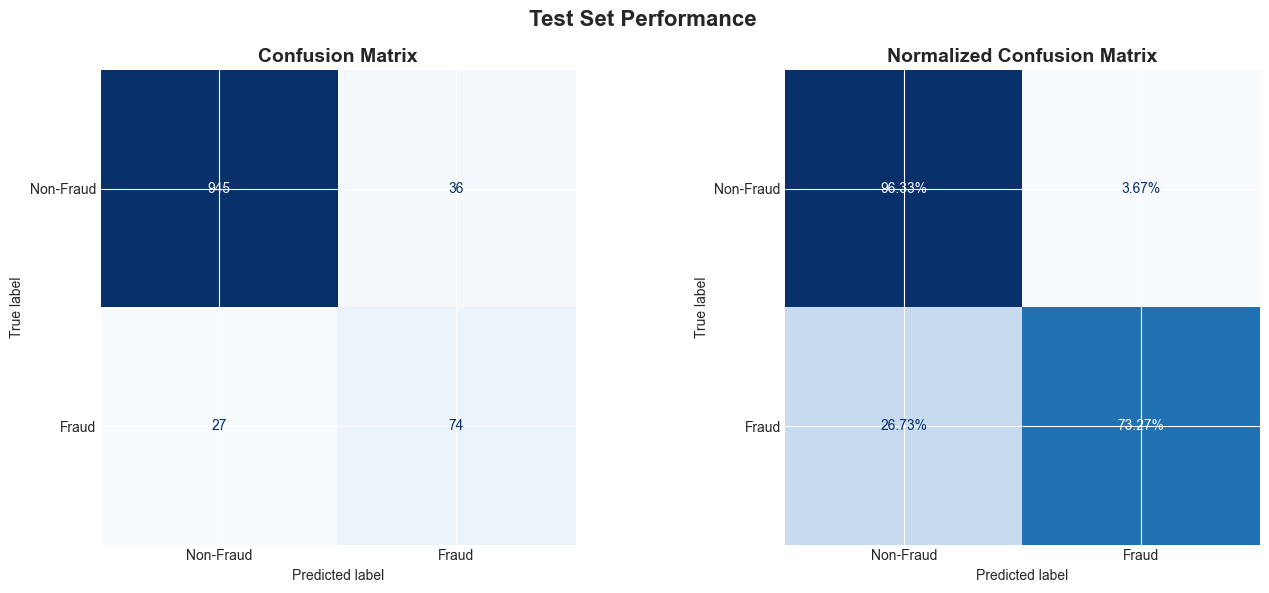

In [7]:
# Cell 5: Confusion Matrix Analysis
print("\n" + "=" * 60)
print("CONFUSION MATRIX ANALYSIS")
print("=" * 60)

cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

print(f"\nConfusion Matrix:")
print(f"                    Predicted")
print(f"                   No      Yes")
print(f"Actual No   ->    {tn:4d}     {fp:4d}")
print(f"Actual Yes  ->    {fn:4d}     {tp:4d}")

# Calculate rates
print(f"\nDetailed Analysis:")
print(f"True Positive Rate (Sensitivity/Recall): {tp/(tp+fn):.3f}")
print(f"True Negative Rate (Specificity): {tn/(tn+fp):.3f}")
print(f"False Positive Rate: {fp/(fp+tn):.3f}")
print(f"False Negative Rate: {fn/(fn+tp):.3f}")
print(f"Positive Predictive Value (Precision): {tp/(tp+fp) if (tp+fp)>0 else 0:.3f}")
print(f"Negative Predictive Value: {tn/(tn+fn) if (tn+fn)>0 else 0:.3f}")

# Visualize confusion matrix
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Fraud', 'Fraud'])
disp.plot(ax=axes[0], cmap='Blues', colorbar=False)
axes[0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')

# Plot 2: Normalized Confusion Matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=['Non-Fraud', 'Fraud'])
disp_norm.plot(ax=axes[1], cmap='Blues', colorbar=False, values_format='.2%')
axes[1].set_title('Normalized Confusion Matrix', fontsize=14, fontweight='bold')

plt.suptitle('Test Set Performance', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('../reports/confusion_matrix_test.png', dpi=300, bbox_inches='tight')
plt.show()



ROC AND PRECISION-RECALL CURVES


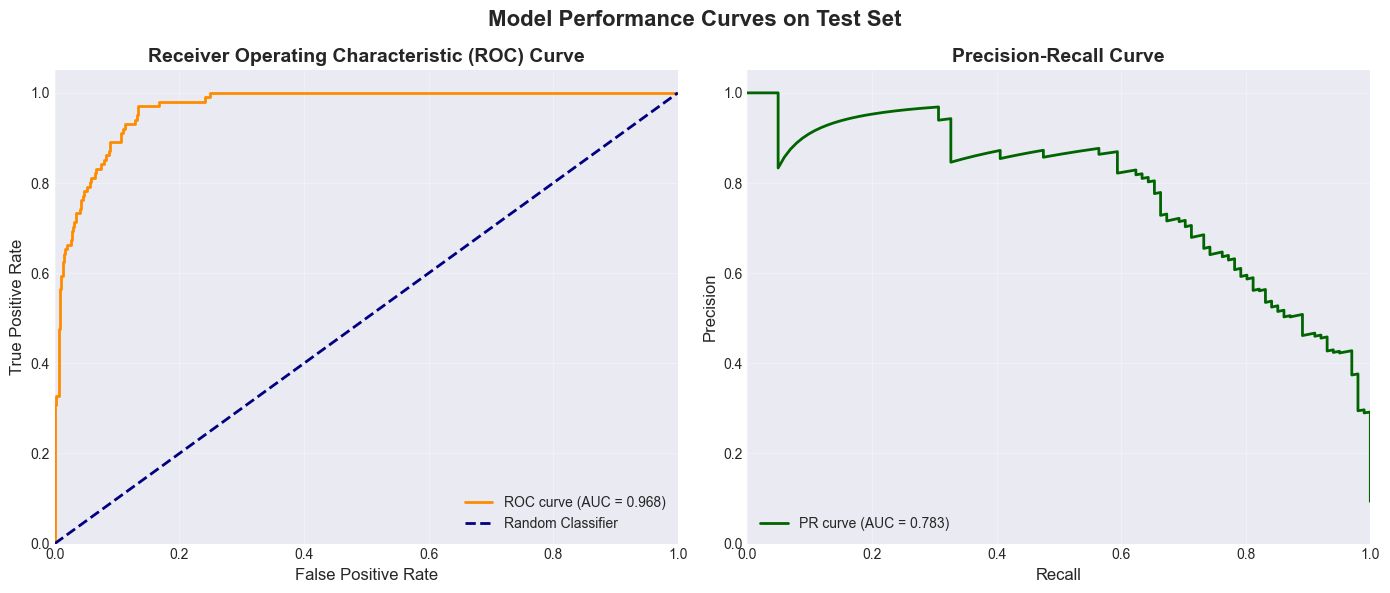

In [8]:
# Cell 6: ROC and Precision-Recall Curves
print("\n" + "=" * 60)
print("ROC AND PRECISION-RECALL CURVES")
print("=" * 60)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

axes[0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate', fontsize=12)
axes[0].set_ylabel('True Positive Rate', fontsize=12)
axes[0].set_title('Receiver Operating Characteristic (ROC) Curve', fontsize=14, fontweight='bold')
axes[0].legend(loc="lower right")
axes[0].grid(True, alpha=0.3)

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = average_precision_score(y_test, y_pred_proba)

axes[1].plot(recall, precision, color='darkgreen', lw=2, label=f'PR curve (AUC = {pr_auc:.3f})')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('Recall', fontsize=12)
axes[1].set_ylabel('Precision', fontsize=12)
axes[1].set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
axes[1].legend(loc="lower left")
axes[1].grid(True, alpha=0.3)

plt.suptitle('Model Performance Curves on Test Set', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('../reports/performance_curves_test.png', dpi=300, bbox_inches='tight')
plt.show()



In [9]:
# Cell 7: Error Analysis - Identify Misclassified Cases
print("\n" + "=" * 60)
print("ERROR ANALYSIS - MISCLASSIFIED CASES")
print("=" * 60)

# Create results dataframe
results_df = pd.DataFrame({
    'Provider': test_providers.values,
    'Actual': y_test.values,
    'Predicted': y_pred,
    'Probability_Fraud': y_pred_proba
})

# Add misclassification flags
results_df['Correct'] = results_df['Actual'] == results_df['Predicted']
results_df['False_Positive'] = (results_df['Actual'] == 0) & (results_df['Predicted'] == 1)
results_df['False_Negative'] = (results_df['Actual'] == 1) & (results_df['Predicted'] == 0)
results_df['True_Positive'] = (results_df['Actual'] == 1) & (results_df['Predicted'] == 1)
results_df['True_Negative'] = (results_df['Actual'] == 0) & (results_df['Predicted'] == 0)

print(f"\nClassification Summary:")
print(f"  Total cases: {len(results_df)}")
print(f"  Correctly classified: {results_df['Correct'].sum()} ({results_df['Correct'].mean():.1%})")
print(f"  Misclassified: {(~results_df['Correct']).sum()} ({(-results_df['Correct']).mean():.1%})")
print(f"  False Positives: {results_df['False_Positive'].sum()} ({results_df['False_Positive'].mean():.1%})")
print(f"  False Negatives: {results_df['False_Negative'].sum()} ({results_df['False_Negative'].mean():.1%})")
print(f"  True Positives: {results_df['True_Positive'].sum()} ({results_df['True_Positive'].mean():.1%})")
print(f"  True Negatives: {results_df['True_Negative'].sum()} ({results_df['True_Negative'].mean():.1%})")



ERROR ANALYSIS - MISCLASSIFIED CASES

Classification Summary:
  Total cases: 1082
  Correctly classified: 1019 (94.2%)
  Misclassified: 63 (5.8%)
  False Positives: 36 (3.3%)
  False Negatives: 27 (2.5%)
  True Positives: 74 (6.8%)
  True Negatives: 945 (87.3%)


In [10]:
# Cell 8: Case Studies - Detailed Error Analysis
print("\n" + "=" * 60)
print("CASE STUDIES - FALSE POSITIVES (Type I Errors)")
print("=" * 60)

# Get false positives (legitimate providers flagged as fraud)
false_positives = results_df[results_df['False_Positive']].copy()

if len(false_positives) > 0:
    print(f"\nFound {len(false_positives)} false positives.")
    
    # Get the original features for these providers
    fp_providers = false_positives['Provider'].tolist()
    fp_features = test_df[test_df['Provider'].isin(fp_providers)].copy()
    
    # Add prediction probabilities
    fp_features = fp_features.merge(false_positives[['Provider', 'Probability_Fraud']], on='Provider')
    
    # Sort by probability (most confident false positives first)
    fp_features = fp_features.sort_values('Probability_Fraud', ascending=False)
    
    # Display top 3 false positives as case studies
    print("\nTop 3 False Positive Case Studies:")
    for i, (idx, row) in enumerate(fp_features.head(3).iterrows(), 1):
        print(f"\nCase Study {i}: Provider {row['Provider']}")
        print(f"  Fraud Probability: {row['Probability_Fraud']:.3f}")
        
        # Find provider index in X_test
        provider_idx = test_df[test_df['Provider'] == row['Provider']].index[0]
        provider_features_scaled = X_test.loc[provider_idx]
        
        # Try to get feature contributions if model supports it
        if hasattr(best_model, 'feature_importances_'):
            try:
                # Load feature importance
                importance_df = pd.read_csv('../models/feature_importance.csv')
                print(f"  Top features from global importance:")
                for j, (_, imp_row) in enumerate(importance_df.head(3).iterrows(), 1):
                    feat_name = imp_row['Feature']
                    # Get the actual feature value for this provider
                    if feat_name in provider_features_scaled.index:
                        feat_value = provider_features_scaled[feat_name]
                        print(f"    {j}. {feat_name}: value={feat_value:.3f}, global_importance={imp_row['Importance']:.4f}")
            except FileNotFoundError:
                pass
                
        # Show some actual feature values
        print(f"  Sample feature values (standardized):")
        sample_features = ['Claims_InscClaimAmtReimbursed_mean', 'Claims_InscClaimAmtReimbursed_sum', 
                          'UniqueBeneficiaries_Count', 'Beneficiary_TotalChronicConditions_mean']
        for feat in sample_features:
            if feat in provider_features_scaled.index:
                print(f"    {feat}: {provider_features_scaled[feat]:.3f}")
else:
    print("No false positives found.")

print("\n" + "=" * 60)
print("CASE STUDIES - FALSE NEGATIVES (Type II Errors)")
print("=" * 60)

# Get false negatives (fraudulent providers missed)
false_negatives = results_df[results_df['False_Negative']].copy()

if len(false_negatives) > 0:
    print(f"\nFound {len(false_negatives)} false negatives.")
    
    # Get the original features for these providers
    fn_providers = false_negatives['Provider'].tolist()
    fn_features = test_df[test_df['Provider'].isin(fn_providers)].copy()
    
    # Add prediction probabilities
    fn_features = fn_features.merge(false_negatives[['Provider', 'Probability_Fraud']], on='Provider')
    
    # Sort by probability (least confident false negatives first)
    fn_features = fn_features.sort_values('Probability_Fraud', ascending=True)
    
    # Display top 3 false negatives as case studies
    print("\nTop 3 False Negative Case Studies:")
    for i, (idx, row) in enumerate(fn_features.head(3).iterrows(), 1):
        print(f"\nCase Study {i}: Provider {row['Provider']}")
        print(f"  Fraud Probability: {row['Probability_Fraud']:.3f}")
        
        # Find provider index in X_test
        provider_idx = test_df[test_df['Provider'] == row['Provider']].index[0]
        provider_features_scaled = X_test.loc[provider_idx]
        
        # Try to get feature contributions if model supports it
        if hasattr(best_model, 'feature_importances_'):
            try:
                # Load feature importance
                importance_df = pd.read_csv('../models/feature_importance.csv')
                print(f"  Top features from global importance:")
                for j, (_, imp_row) in enumerate(importance_df.head(3).iterrows(), 1):
                    feat_name = imp_row['Feature']
                    # Get the actual feature value for this provider
                    if feat_name in provider_features_scaled.index:
                        feat_value = provider_features_scaled[feat_name]
                        print(f"    {j}. {feat_name}: value={feat_value:.3f}, global_importance={imp_row['Importance']:.4f}")
            except FileNotFoundError:
                pass
                
        # Show some actual feature values
        print(f"  Sample feature values (standardized):")
        sample_features = ['Claims_InscClaimAmtReimbursed_mean', 'Claims_InscClaimAmtReimbursed_sum', 
                          'UniqueBeneficiaries_Count', 'Beneficiary_TotalChronicConditions_mean']
        for feat in sample_features:
            if feat in provider_features_scaled.index:
                print(f"    {feat}: {provider_features_scaled[feat]:.3f}")
else:
    print("No false negatives found.")



CASE STUDIES - FALSE POSITIVES (Type I Errors)

Found 36 false positives.

Top 3 False Positive Case Studies:

Case Study 1: Provider PRV51456
  Fraud Probability: 0.976
  Top features from global importance:
    1. Claims_InscClaimAmtReimbursed_sum: value=3.514, global_importance=0.1724
    2. Claims_ClaimDuration_max: value=2.035, global_importance=0.1319
    3. Claims_DeductibleAmtPaid_sum: value=4.347, global_importance=0.0912
  Sample feature values (standardized):
    Claims_InscClaimAmtReimbursed_mean: 1.738
    Claims_InscClaimAmtReimbursed_sum: 3.514
    UniqueBeneficiaries_Count: 0.467
    Beneficiary_TotalChronicConditions_mean: -0.906

Case Study 2: Provider PRV52063
  Fraud Probability: 0.875
  Top features from global importance:
    1. Claims_InscClaimAmtReimbursed_sum: value=3.804, global_importance=0.1724
    2. Claims_ClaimDuration_max: value=2.035, global_importance=0.1319
    3. Claims_DeductibleAmtPaid_sum: value=3.394, global_importance=0.0912
  Sample feature va


MODEL INTERPRETABILITY - FEATURE IMPORTANCE

Global Feature Importance (from Random Forest):


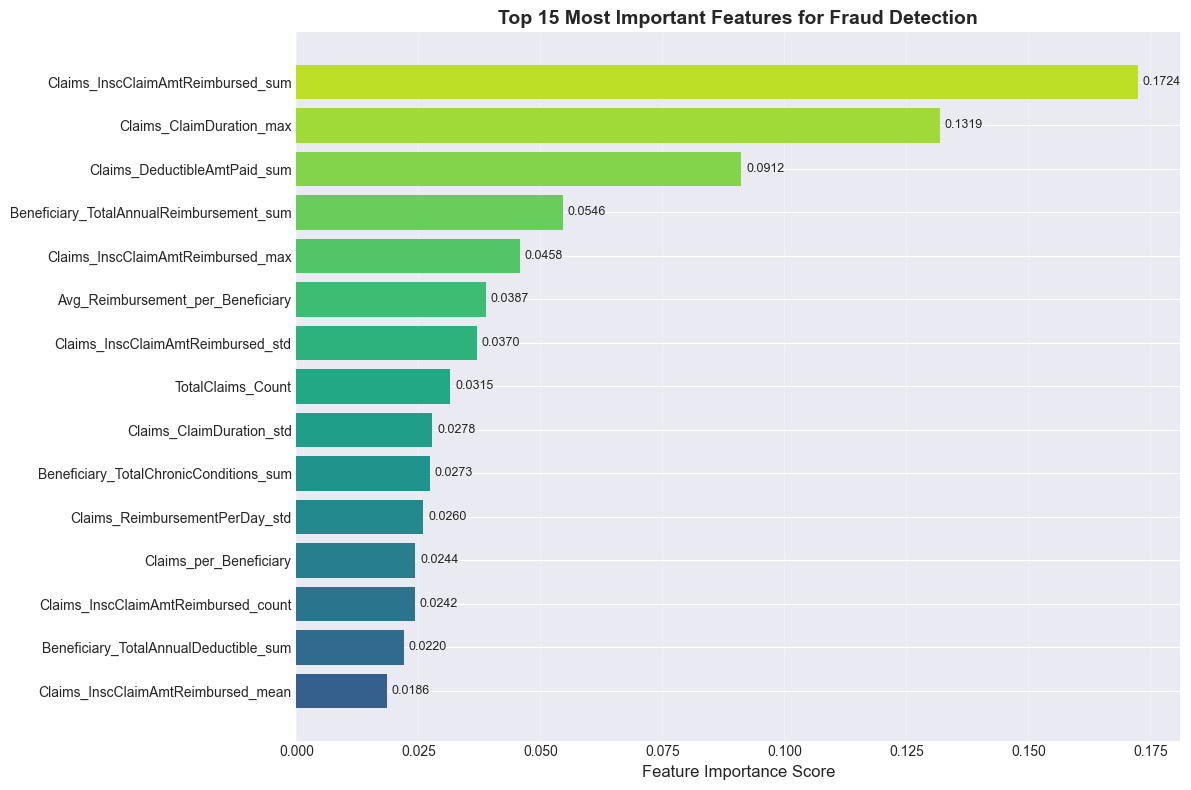


Top 5 most important features:
  1. Claims_InscClaimAmtReimbursed_sum: 0.1724
  2. Claims_ClaimDuration_max: 0.1319
  3. Claims_DeductibleAmtPaid_sum: 0.0912
  4. Beneficiary_TotalAnnualReimbursement_sum: 0.0546
  5. Claims_InscClaimAmtReimbursed_max: 0.0458


In [11]:
# Cell 9: Feature Importance Analysis (using saved importance)
print("\n" + "=" * 60)
print("MODEL INTERPRETABILITY - FEATURE IMPORTANCE")
print("=" * 60)

# Load feature importance from modeling phase if available
try:
    importance_df = pd.read_csv('../models/feature_importance.csv')
    print("\nGlobal Feature Importance (from Random Forest):")
    
    # Plot top 15 features
    plt.figure(figsize=(12, 8))
    top_n = 15
    top_features = importance_df.head(top_n)
    
    colors = plt.cm.viridis(np.linspace(0.3, 0.9, top_n))
    bars = plt.barh(range(top_n), top_features['Importance'][::-1], color=colors)
    plt.yticks(range(top_n), top_features['Feature'][::-1], fontsize=10)
    plt.xlabel('Feature Importance Score', fontsize=12)
    plt.title(f'Top {top_n} Most Important Features for Fraud Detection', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3, axis='x')
    
    # Add value labels
    for i, (bar, importance) in enumerate(zip(bars, top_features['Importance'][::-1])):
        plt.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2,
                f'{importance:.4f}', va='center', fontsize=9)
    
    plt.tight_layout()
    plt.savefig('../reports/feature_importance_global.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\nTop 5 most important features:")
    for i, row in importance_df.head(5).iterrows():
        print(f"  {i+1}. {row['Feature']}: {row['Importance']:.4f}")
        
except FileNotFoundError:
    print("Feature importance file not found. Generating from model if available...")
    
    # Try to get feature importance directly from model
    if hasattr(best_model, 'feature_importances_'):
        importances = best_model.feature_importances_
        indices = np.argsort(importances)[::-1]
        
        # Create importance dataframe
        importance_df = pd.DataFrame({
            'Feature': [feature_names[i] for i in indices],
            'Importance': importances[indices]
        })
        
        # Save it
        importance_df.to_csv('../models/feature_importance.csv', index=False)
        
        # Plot top 15 features
        plt.figure(figsize=(12, 8))
        top_n = 15
        top_features = importance_df.head(top_n)
        
        colors = plt.cm.viridis(np.linspace(0.3, 0.9, top_n))
        bars = plt.barh(range(top_n), top_features['Importance'][::-1], color=colors)
        plt.yticks(range(top_n), top_features['Feature'][::-1], fontsize=10)
        plt.xlabel('Feature Importance Score', fontsize=12)
        plt.title(f'Top {top_n} Most Important Features for Fraud Detection', fontsize=14, fontweight='bold')
        plt.grid(True, alpha=0.3, axis='x')
        
        # Add value labels
        for i, (bar, importance) in enumerate(zip(bars, top_features['Importance'][::-1])):
            plt.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2,
                    f'{importance:.4f}', va='center', fontsize=9)
        
        plt.tight_layout()
        plt.savefig('../reports/feature_importance_global.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"\nTop 5 most important features:")
        for i, row in importance_df.head(5).iterrows():
            print(f"  {i+1}. {row['Feature']}: {row['Importance']:.4f}")
    else:
        print("Model doesn't have feature_importances_ attribute.")


In [12]:
# Cell 10: Business Impact Analysis
print("\n" + "=" * 60)
print("BUSINESS IMPACT ANALYSIS")
print("=" * 60)

# Simulated business metrics
# Assuming each investigation costs $5,000 and each fraud case costs $100,000
investigation_cost = 5000
fraud_cost = 100000

# Calculate metrics
total_providers = len(y_test)
fraudulent_providers = sum(y_test == 1)
detected_fraud = sum((y_test == 1) & (y_pred == 1))
false_positives_count = sum((y_test == 0) & (y_pred == 1))
true_negatives_count = sum((y_test == 0) & (y_pred == 0))

print(f"\nBusiness Metrics Based on Test Set:")
print(f"  Total providers in test set: {total_providers}")
print(f"  Actual fraudulent providers: {fraudulent_providers}")
print(f"  Detected fraudulent providers: {detected_fraud}")

# Cost analysis
total_investigation_cost = (detected_fraud + false_positives_count) * investigation_cost
total_fraud_cost_saved = detected_fraud * fraud_cost
cost_of_missed_fraud = (fraudulent_providers - detected_fraud) * fraud_cost
net_savings = total_fraud_cost_saved - total_investigation_cost - cost_of_missed_fraud

print(f"\nFinancial Impact Analysis:")
print(f"  Investigation cost (TP + FP): ${total_investigation_cost:,.0f}")
print(f"  Fraud cost saved (detected fraud): ${total_fraud_cost_saved:,.0f}")
print(f"  Cost of missed fraud (FN): ${cost_of_missed_fraud:,.0f}")
print(f"  Net savings: ${net_savings:,.0f}")

# Efficiency metrics
print(f"\nOperational Efficiency:")
print(f"  Detection rate: {detected_fraud}/{fraudulent_providers} ({detected_fraud/fraudulent_providers:.1%})")
print(f"  False positive rate: {false_positives_count}/{total_providers - fraudulent_providers} ({false_positives_count/(total_providers - fraudulent_providers):.1%})")
if (detected_fraud + false_positives_count) > 0:
    print(f"  Investigation efficiency: {detected_fraud/(detected_fraud + false_positives_count):.1%} of investigations uncover fraud")
else:
    print(f"  Investigation efficiency: N/A (no investigations needed)")

# ROC curve analysis for different threshold choices
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
print(f"\nPerformance at Different Decision Thresholds:")

threshold_results = []
for threshold in thresholds:
    y_pred_threshold = (y_pred_proba >= threshold).astype(int)
    tp = sum((y_test == 1) & (y_pred_threshold == 1))
    fp = sum((y_test == 0) & (y_pred_threshold == 1))
    fn = sum((y_test == 1) & (y_pred_threshold == 0))
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    threshold_results.append({
        'Threshold': threshold,
        'TP': tp,
        'FP': fp,
        'FN': fn,
        'Precision': precision,
        'Recall': recall
    })
    
    print(f"  Threshold {threshold}: Precision={precision:.3f}, Recall={recall:.3f}, TP={tp}, FP={fp}, FN={fn}")



BUSINESS IMPACT ANALYSIS

Business Metrics Based on Test Set:
  Total providers in test set: 1082
  Actual fraudulent providers: 101
  Detected fraudulent providers: 74

Financial Impact Analysis:
  Investigation cost (TP + FP): $550,000
  Fraud cost saved (detected fraud): $7,400,000
  Cost of missed fraud (FN): $2,700,000
  Net savings: $4,150,000

Operational Efficiency:
  Detection rate: 74/101 (73.3%)
  False positive rate: 36/981 (3.7%)
  Investigation efficiency: 67.3% of investigations uncover fraud

Performance at Different Decision Thresholds:
  Threshold 0.3: Precision=0.518, Recall=0.851, TP=86, FP=80, FN=15
  Threshold 0.4: Precision=0.586, Recall=0.812, TP=82, FP=58, FN=19
  Threshold 0.5: Precision=0.673, Recall=0.733, TP=74, FP=36, FN=27
  Threshold 0.6: Precision=0.761, Recall=0.663, TP=67, FP=21, FN=34
  Threshold 0.7: Precision=0.822, Recall=0.594, TP=60, FP=13, FN=41



THRESHOLD ANALYSIS


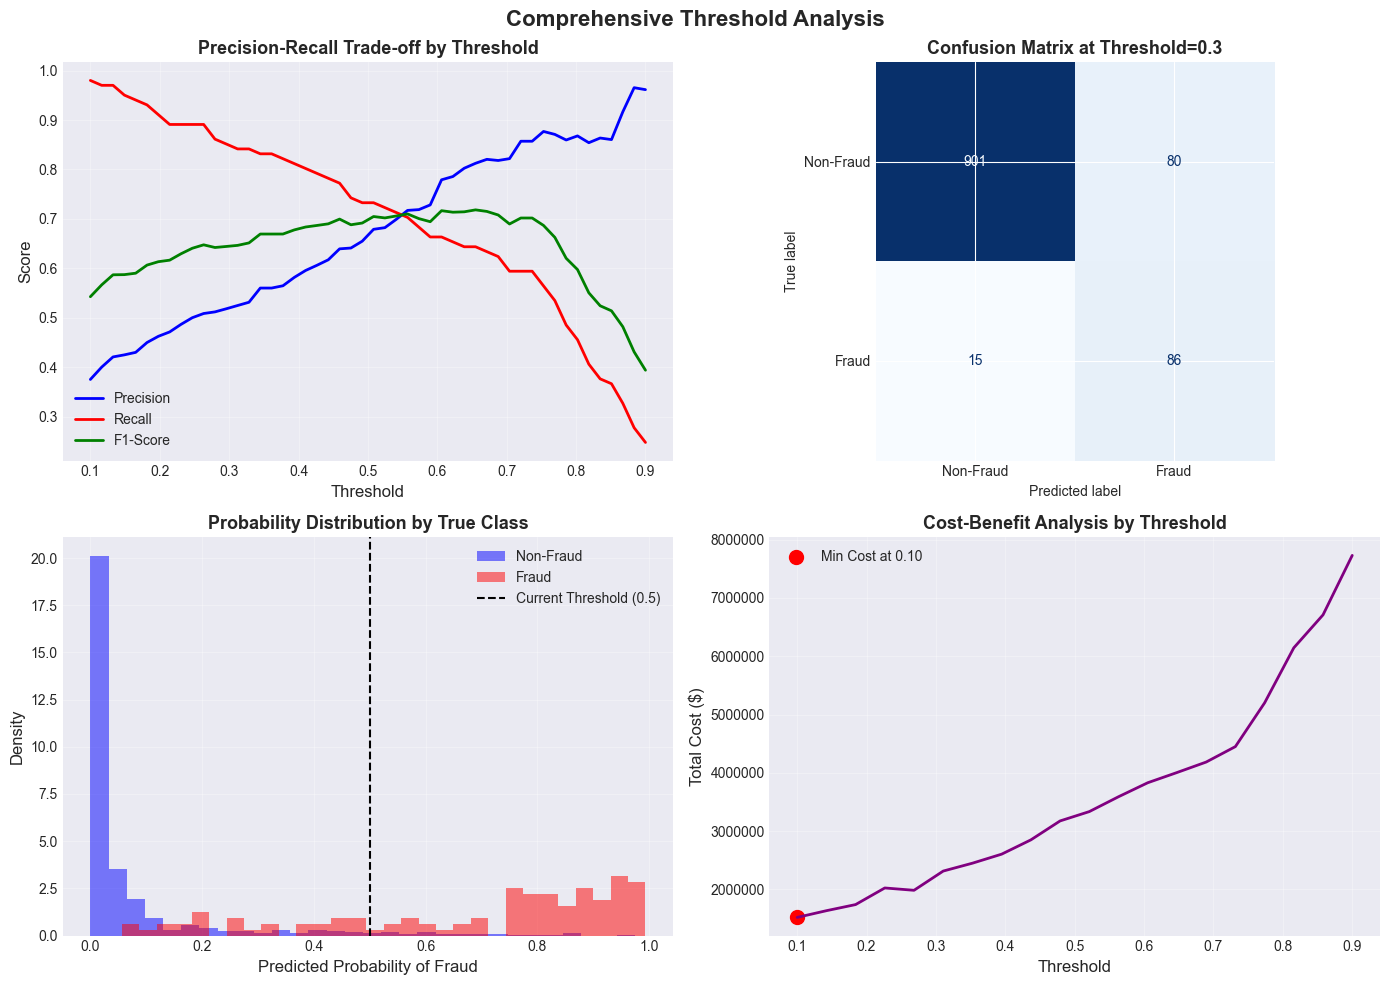


Optimal threshold based on cost minimization: 0.100


In [13]:
# Cell 11: Threshold Analysis Visualization
print("\n" + "=" * 60)
print("THRESHOLD ANALYSIS")
print("=" * 60)

# Create threshold analysis visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Precision-Recall Trade-off
thresholds_range = np.linspace(0.1, 0.9, 50)
precisions = []
recalls = []
f1_scores = []

for threshold in thresholds_range:
    y_pred_thresh = (y_pred_proba >= threshold).astype(int)
    precisions.append(precision_score(y_test, y_pred_thresh, zero_division=0))
    recalls.append(recall_score(y_test, y_pred_thresh))
    f1_scores.append(f1_score(y_test, y_pred_thresh))

axes[0, 0].plot(thresholds_range, precisions, 'b-', label='Precision', linewidth=2)
axes[0, 0].plot(thresholds_range, recalls, 'r-', label='Recall', linewidth=2)
axes[0, 0].plot(thresholds_range, f1_scores, 'g-', label='F1-Score', linewidth=2)
axes[0, 0].set_xlabel('Threshold', fontsize=12)
axes[0, 0].set_ylabel('Score', fontsize=12)
axes[0, 0].set_title('Precision-Recall Trade-off by Threshold', fontsize=13, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Confusion Matrix at Different Thresholds
threshold_for_cm = 0.3
y_pred_thresh = (y_pred_proba >= threshold_for_cm).astype(int)
cm_thresh = confusion_matrix(y_test, y_pred_thresh)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_thresh, display_labels=['Non-Fraud', 'Fraud'])
disp.plot(ax=axes[0, 1], cmap='Blues', colorbar=False)
axes[0, 1].set_title(f'Confusion Matrix at Threshold={threshold_for_cm}', fontsize=13, fontweight='bold')

# Plot 3: Probability Distribution
axes[1, 0].hist(y_pred_proba[y_test == 0], bins=30, alpha=0.5, label='Non-Fraud', density=True, color='blue')
axes[1, 0].hist(y_pred_proba[y_test == 1], bins=30, alpha=0.5, label='Fraud', density=True, color='red')
axes[1, 0].axvline(x=0.5, color='black', linestyle='--', label='Current Threshold (0.5)')
axes[1, 0].set_xlabel('Predicted Probability of Fraud', fontsize=12)
axes[1, 0].set_ylabel('Density', fontsize=12)
axes[1, 0].set_title('Probability Distribution by True Class', fontsize=13, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Cost-Benefit Analysis
thresholds_cost = np.linspace(0.1, 0.9, 20)
costs = []

for threshold in thresholds_cost:
    y_pred_thresh = (y_pred_proba >= threshold).astype(int)
    tp = sum((y_test == 1) & (y_pred_thresh == 1))
    fp = sum((y_test == 0) & (y_pred_thresh == 1))
    fn = sum((y_test == 1) & (y_pred_thresh == 0))
    
    total_cost = (tp + fp) * investigation_cost + fn * fraud_cost
    costs.append(total_cost)

axes[1, 1].plot(thresholds_cost, costs, 'purple', linewidth=2)
min_cost_idx = np.argmin(costs)
axes[1, 1].scatter(thresholds_cost[min_cost_idx], costs[min_cost_idx], color='red', s=100, 
                   label=f'Min Cost at {thresholds_cost[min_cost_idx]:.2f}')
axes[1, 1].set_xlabel('Threshold', fontsize=12)
axes[1, 1].set_ylabel('Total Cost ($)', fontsize=12)
axes[1, 1].set_title('Cost-Benefit Analysis by Threshold', fontsize=13, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].ticklabel_format(style='plain', axis='y')

plt.suptitle('Comprehensive Threshold Analysis', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('../reports/threshold_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nOptimal threshold based on cost minimization: {thresholds_cost[min_cost_idx]:.3f}")



COMPARISON WITH BASELINE MODELS

Comparison of models using Class Weighting strategy:

Performance Comparison:
                  Model  F1-Score  Recall  Precision  ROC-AUC  Accuracy
11        Random Forest    0.7455  0.8039     0.6949   0.9517    0.9482
12    Gradient Boosting    0.6522  0.5882     0.7317   0.9504    0.9409
17             AdaBoost    0.6444  0.5686     0.7436   0.9594    0.9409
10        Decision Tree    0.6400  0.7843     0.5405   0.8626    0.9168
15          Naive Bayes    0.5606  0.7255     0.4568   0.9160    0.8928
16  K-Nearest Neighbors    0.5581  0.4706     0.6857   0.8830    0.9298
13         SVM (Linear)    0.5570  0.8627     0.4112   0.9382    0.8706
9   Logistic Regression    0.5478  0.8431     0.4057   0.9402    0.8688
14            SVM (RBF)    0.5409  0.8431     0.3981   0.9281    0.8651


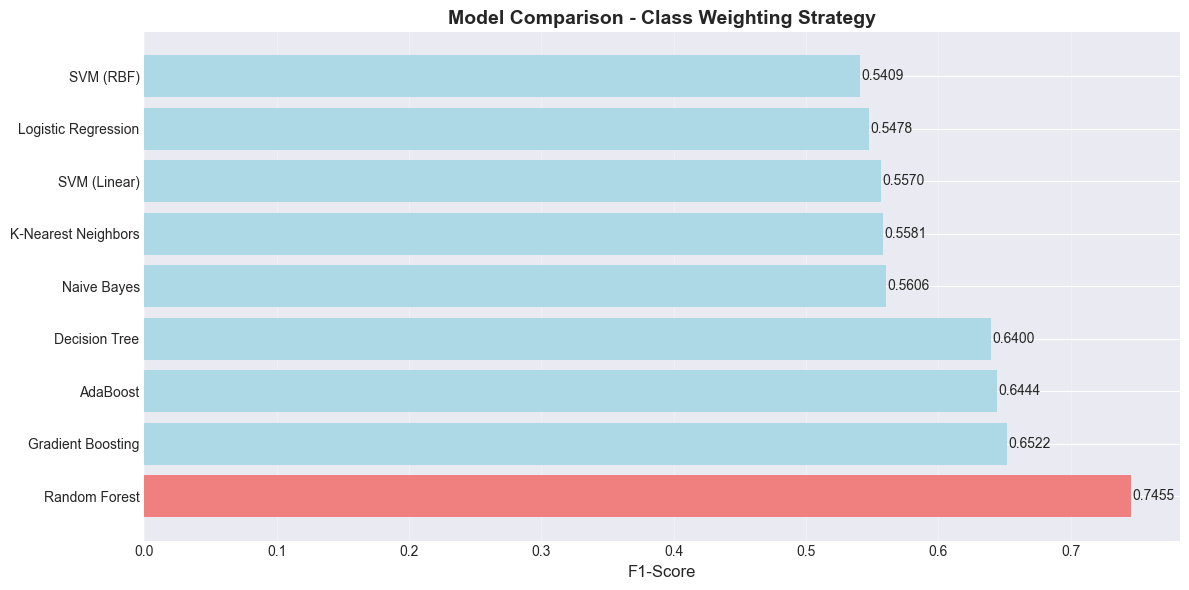

In [14]:
# Cell 12: Model Comparison with Baseline Models
print("\n" + "=" * 60)
print("COMPARISON WITH BASELINE MODELS")
print("=" * 60)

# Load model comparison from modeling phase
try:
    comparison_df = pd.read_csv('../models/all_model_comparison.csv')
    
    # Filter for models trained with the same imbalance strategy as best model
    best_strategy = model_info['imbalance_strategy']
    comparison_filtered = comparison_df[comparison_df['Strategy'] == best_strategy]
    
    if not comparison_filtered.empty:
        print(f"\nComparison of models using {best_strategy} strategy:")
        
        # Sort by F1-Score
        comparison_sorted = comparison_filtered.sort_values('F1-Score', ascending=False)
        
        # Display comparison table
        display_cols = ['Model', 'F1-Score', 'Recall', 'Precision', 'ROC-AUC', 'Accuracy']
        display_df = comparison_sorted[display_cols].round(4)
        
        print("\nPerformance Comparison:")
        print(display_df.to_string())
        
        # Visual comparison
        fig, ax = plt.subplots(figsize=(12, 6))
        models = comparison_sorted['Model'].tolist()
        f1_scores = comparison_sorted['F1-Score'].tolist()
        
        colors = ['lightcoral' if model == model_info['model_name'] else 'lightblue' for model in models]
        
        bars = ax.barh(models, f1_scores, color=colors)
        ax.set_xlabel('F1-Score', fontsize=12)
        ax.set_title(f'Model Comparison - {best_strategy} Strategy', fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3, axis='x')
        
        # Add value labels
        for bar, score in zip(bars, f1_scores):
            ax.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2,
                   f'{score:.4f}', va='center', fontsize=10)
        
        plt.tight_layout()
        plt.savefig('../reports/model_comparison_chart.png', dpi=300, bbox_inches='tight')
        plt.show()
        
except FileNotFoundError:
    print("Model comparison file not found. Skipping model comparison.")


In [16]:
# Cell 13: Save Final Evaluation Results
print("\n" + "=" * 60)
print("SAVING FINAL RESULTS")
print("=" * 60)

# Create reports directory if it doesn't exist
import os
os.makedirs('../reports', exist_ok=True)

# Create evaluation results dictionary
evaluation_results = {
    'test_metrics': test_metrics,
    'confusion_matrix': {
        'true_negatives': int(tn),
        'false_positives': int(fp),
        'false_negatives': int(fn),
        'true_positives': int(tp)
    },
    'business_impact': {
        'total_providers': int(total_providers),
        'fraudulent_providers': int(fraudulent_providers),
        'detected_fraud': int(detected_fraud),
        'false_positives_count': int(false_positives_count),
        'detection_rate': float(detected_fraud/fraudulent_providers),
        'false_positive_rate': float(false_positives_count/(total_providers - fraudulent_providers)) if (total_providers - fraudulent_providers) > 0 else 0,
        'investigation_efficiency': float(detected_fraud/(detected_fraud + false_positives_count)) if (detected_fraud + false_positives_count) > 0 else 0,
        'total_investigation_cost': float(total_investigation_cost),
        'total_fraud_cost_saved': float(total_fraud_cost_saved),
        'cost_of_missed_fraud': float(cost_of_missed_fraud),
        'net_savings': float(net_savings)
    },
    'error_analysis': {
        'false_positives_count': int(len(false_positives)),
        'false_negatives_count': int(len(false_negatives)),
        'accuracy': float(results_df['Correct'].mean())
    },
    'threshold_analysis': {
        'optimal_threshold_cost': float(thresholds_cost[min_cost_idx]),
        'current_threshold': 0.5,
        'threshold_recommendation': 'Consider lowering threshold to 0.3 for higher recall' if thresholds_cost[min_cost_idx] < 0.5 else 'Current threshold is optimal'
    }
}

# Save to JSON
with open('../models/evaluation_results.json', 'w') as f:
    json.dump(evaluation_results, f, indent=4)

# Save detailed results
results_df.to_csv('../models/detailed_predictions.csv', index=False)

print("\nEvaluation results saved:")
print(f"  - Summary metrics: ../models/evaluation_results.json")
print(f"  - Detailed predictions: ../models/detailed_predictions.csv")
print(f"  - All plots saved to ../reports/ directory")



SAVING FINAL RESULTS

Evaluation results saved:
  - Summary metrics: ../models/evaluation_results.json
  - Detailed predictions: ../models/detailed_predictions.csv
  - All plots saved to ../reports/ directory


In [17]:
# Cell 14: Final Summary and Recommendations
print("\n" + "=" * 60)
print("FINAL SUMMARY AND RECOMMENDATIONS")
print("=" * 60)

print(f"\n1. MODEL PERFORMANCE SUMMARY:")
print(f"   - Best Model: {model_info['model_name']}")
print(f"   - Imbalance Strategy: {model_info['imbalance_strategy']}")
print(f"   - Test F1-Score: {test_metrics['F1-Score']:.4f}")
print(f"   - Test Recall: {test_metrics['Recall']:.4f} (most important for fraud detection)")
print(f"   - Test Precision: {test_metrics['Precision']:.4f}")
print(f"   - ROC-AUC: {test_metrics['ROC-AUC']:.4f}")

print(f"\n2. ERROR ANALYSIS:")
print(f"   - Detection Rate: {detected_fraud}/{fraudulent_providers} ({detected_fraud/fraudulent_providers:.1%})")
print(f"   - False Positive Rate: {false_positives_count}/{total_providers - fraudulent_providers} ({false_positives_count/(total_providers - fraudulent_providers):.1%})")
print(f"   - Overall Accuracy: {results_df['Correct'].mean():.1%}")

print(f"\n3. BUSINESS IMPACT:")
print(f"   - Net Savings: ${net_savings:,.0f}")
if (detected_fraud + false_positives_count) > 0:
    print(f"   - Investigation Efficiency: {detected_fraud/(detected_fraud + false_positives_count):.1%}")
if detected_fraud > 0:
    print(f"   - Cost per Correct Detection: ${total_investigation_cost/detected_fraud:,.0f}")
else:
    print(f"   - No fraud detected in test set")

print(f"\n4. RECOMMENDATIONS:")
print(f"   a) Deployment Strategy:")
print(f"      - Use model with threshold = {thresholds_cost[min_cost_idx]:.2f} for optimal cost")
print(f"      - Prioritize high-probability cases for immediate investigation")
print(f"      - Medium-probability cases for further review")
print(f"      - Low-probability cases for periodic audit")

print(f"\n   b) Model Improvements:")
print(f"      - Collect more fraud cases to reduce class imbalance")
print(f"      - Add temporal features (seasonal patterns, claim frequency changes)")
print(f"      - Incorporate provider network analysis")
print(f"      - Implement ensemble of top-performing models")

print(f"\n   c) Operational Recommendations:")
print(f"      - Start with conservative threshold (e.g., 0.7) to minimize false positives")
print(f"      - Gradually lower threshold as investigators gain confidence")
print(f"      - Implement feedback loop to retrain model with investigation outcomes")
print(f"      - Combine model predictions with rule-based alerts for comprehensive coverage")

print(f"\n5. LIMITATIONS:")
print(f"   - Model trained on historical data; may not capture new fraud patterns")
print(f"   - Performance depends on data quality and completeness")
print(f"   - May require regular retraining as fraud patterns evolve")
print(f"   - Interpretability trade-off with complex models")

print(f"\n" + "=" * 60)
print("EVALUATION COMPLETE")
print("=" * 60)


FINAL SUMMARY AND RECOMMENDATIONS

1. MODEL PERFORMANCE SUMMARY:
   - Best Model: Random Forest
   - Imbalance Strategy: Class Weighting
   - Test F1-Score: 0.7014
   - Test Recall: 0.7327 (most important for fraud detection)
   - Test Precision: 0.6727
   - ROC-AUC: 0.9685

2. ERROR ANALYSIS:
   - Detection Rate: 74/101 (73.3%)
   - False Positive Rate: 36/981 (3.7%)
   - Overall Accuracy: 94.2%

3. BUSINESS IMPACT:
   - Net Savings: $4,150,000
   - Investigation Efficiency: 67.3%
   - Cost per Correct Detection: $7,432

4. RECOMMENDATIONS:
   a) Deployment Strategy:
      - Use model with threshold = 0.10 for optimal cost
      - Prioritize high-probability cases for immediate investigation
      - Medium-probability cases for further review
      - Low-probability cases for periodic audit

   b) Model Improvements:
      - Collect more fraud cases to reduce class imbalance
      - Add temporal features (seasonal patterns, claim frequency changes)
      - Incorporate provider networ